In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-04-06 05:33:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-04-06 05:33:00 (112 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



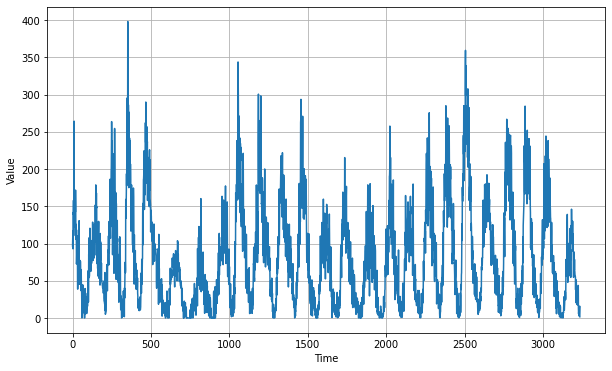

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

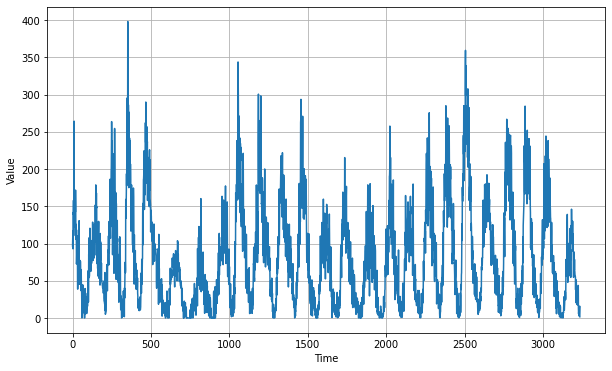

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 34s 31ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 0s 27ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 0s 28ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 0s 28ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 0s 28ms/step - loss: 62.9767 - mae: 63.4739
Epoch 7/100
12/12 [==============================] - 0s 29ms/step - loss: 59.8143 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 0s 29ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 0s 28ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

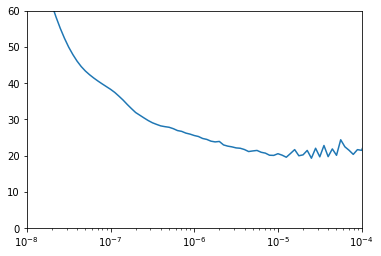

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=700)

Epoch 1/700
30/30 [==============================] - 3s 16ms/step - loss: 47.7134 - mae: 48.2106
Epoch 2/700
30/30 [==============================] - 1s 15ms/step - loss: 26.8674 - mae: 27.3623
Epoch 3/700
30/30 [==============================] - 1s 15ms/step - loss: 22.9797 - mae: 23.4742
Epoch 4/700
30/30 [==============================] - 1s 15ms/step - loss: 20.2830 - mae: 20.7761
Epoch 5/700
30/30 [==============================] - 1s 15ms/step - loss: 19.2674 - mae: 19.7599
Epoch 6/700
30/30 [==============================] - 1s 16ms/step - loss: 19.6373 - mae: 20.1296
Epoch 7/700
30/30 [==============================] - 1s 15ms/step - loss: 18.6215 - mae: 19.1135
Epoch 8/700
30/30 [==============================] - 1s 16ms/step - loss: 17.9342 - mae: 18.4255
Epoch 9/700
30/30 [==============================] - 1s 17ms/step - loss: 17.9558 - mae: 18.4471
Epoch 10/700
30/30 [==============================] - 1s 16ms/step - loss: 20.1220 - mae: 20.6143
Epoch 11/700
30/30 [=========

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

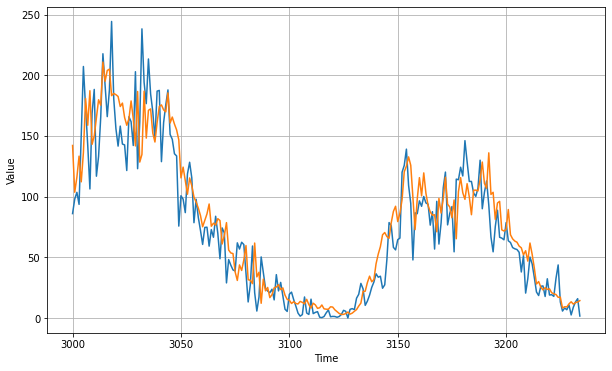

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.603985

<Figure size 432x288 with 0 Axes>

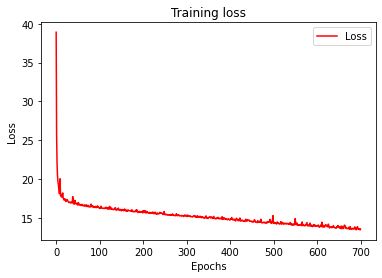

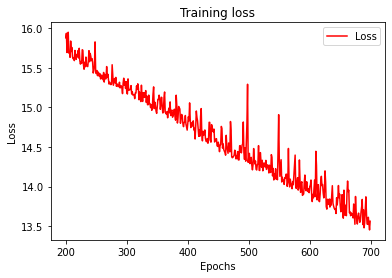

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,700)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [23]:
print(rnn_forecast)

[142.12297   103.59259   116.0244    133.33012   112.161865  136.2633
 180.86041   158.78058   187.2364    143.0788    150.01314   164.66821
 179.79181   175.31049   210.82353   194.96487   203.92453   205.02396
 183.18484   185.02324   183.97977   182.50403   174.20903   177.04652
 165.24861   158.78738   164.17555   178.81903   164.22092   141.75012
 186.59758   128.44553   134.73991   186.86513   148.19673   171.07089
 172.26816   152.37871   144.9817    161.01973   174.2169    175.55887
 171.48215   169.82352   185.45293   160.63066   165.54703   159.7538
 154.92981   146.76456   115.44738   124.29386   112.92852   101.936386
 115.38142   108.96229    99.63119    95.484634   90.5724     84.444466
  75.123795   80.5147     85.754395   93.906006   75.56869    78.101364
  76.510635   81.81481    80.2755     60.958458   67.82879    78.55646
  55.99106    53.583252   53.04389    37.893127   30.931177   43.711002
  39.147526   47.730446   59.659447   31.529707   31.070816   28.319427
  6